<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/ns_2_module5_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%config IPComplater.greedy = True

In [33]:
from google.colab import drive
drive.mount('./DRIVE', force_remount=True)

Mounted at ./DRIVE


In [34]:
!rm -rf input && unzip "./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/test.zip" -d input \
 && unzip "./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/train.zip" -d input \
 && cp "./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/sample-submission.csv" input \
 && cp "./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/train.csv" input \
 && mv input/test_upload input/test

Archive:  ./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/test.zip
   creating: input/test_upload/
  inflating: input/test_upload/97344.jpg  
  inflating: input/test_upload/48172.jpg  
  inflating: input/test_upload/86074.jpg  
  inflating: input/test_upload/95406.jpg  
  inflating: input/test_upload/52289.jpg  
  inflating: input/test_upload/87970.jpg  
  inflating: input/test_upload/54540.jpg  
  inflating: input/test_upload/3985.jpg  
  inflating: input/test_upload/5212.jpg  
  inflating: input/test_upload/89920.jpg  
  inflating: input/test_upload/298734.jpg  
  inflating: input/test_upload/307551.jpg  
  inflating: input/test_upload/42452.jpg  
  inflating: input/test_upload/29780.jpg  
  inflating: input/test_upload/67521.jpg  
  inflating: input/test_upload/69701.jpg  
  inflating: input/test_upload/35923.jpg  
  inflating: input/test_upload/58281.jpg  
  inflating: input/test_upload/29931.jpg  
  inflating: input/test_upload/38337.jpg  
  inflating: input/test_upload/91663.jpg  
 

> Это пример решения данной задачи с использованием Keras. Вы можете использовать этот кернал для дальнейших своих исследований и эксперементов.
# Car classification
![](http://img1.joyreactor.cc/pics/post/автопром-ваз-лимузин-ватермарк-351083.jpeg)

### Основная идея - берем предобученую на imagenet сеть Xception и дообучаем под нашу задачу.
По ходу кернела я буду давать комментарии и подсказки (где что можно подкрутить и что можно еще попробовать, чтоб улучшить скор).  
Многие параметры специально установлены не оптимальным образом ;)

Удачи и Поехали!

In [35]:
!pip show keras

Name: Keras
Version: 2.2.5
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: keras-applications, scipy, pyyaml, keras-preprocessing, six, numpy, h5py
Required-by: 


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import csv
import os

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.callbacks import Callback
from keras.regularizers import l2
from keras import optimizers
from keras.models import Model
from keras.utils import np_utils
from keras.applications.xception import Xception
from keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("input"))

['sample-submission.csv', 'train', 'train.csv', 'test']


# Setup

In [0]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS               = 5
BATCH_SIZE           = 32
LR                   = 1e-4

CLASS_NUM            = 10
IMG_SIZE             = 224
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = 'input/'
PATH = "working/car/"

In [0]:
!rm -rf working/car/
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

from tensorflow import set_random_seed
set_random_seed(RANDOM_SEED)

# EDA / Анализ данных

In [40]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
Id          15561 non-null object
Category    15561 non-null int64
dtypes: int64(1), object(1)
memory usage: 243.2+ KB


In [42]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Пример картинок (random sample)


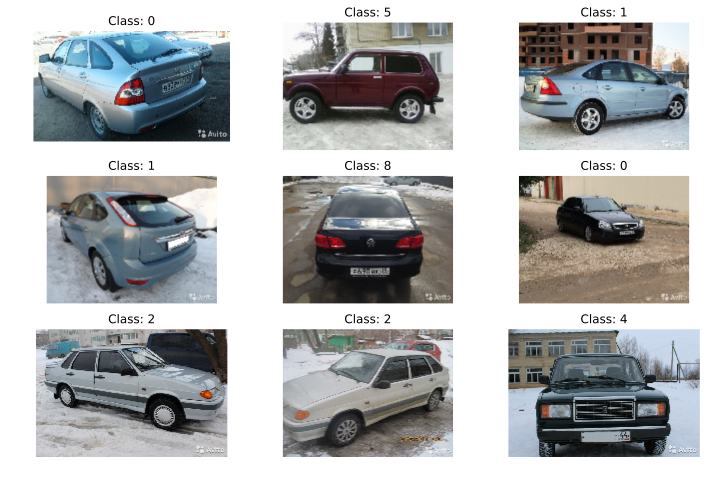

In [43]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

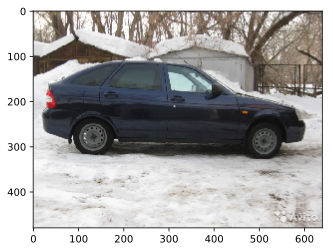

(640, 480)

In [44]:
image = PIL.Image.open(DATA_PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

### Уже догадался что означают классы?
### Тогда перейдем к подготовке данных...
![](http://admem.ru/content/images/1391000424.jpg)

# Data

### Data augmentation

In [0]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)
# Поиграйся тут параметрами чтоб понять что к чему. 
# Официальная дока https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.1, # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Задание для Про - попробуй подключить сторонние более продвинутые библиотеки аугминтации изображений

### datagen

In [0]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=DATA_PATH+'test',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# кстати, ты заметил, что для сабмишена мы используем другой источник для генератора flow_from_dataframe? 
# Как ты думаешь, почему?

# Model

### подгружаем предобученую сеть Xception

In [0]:
# Кстати Попробуй еще другие архитектуры сетей...
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [0]:
base_model.summary()

In [0]:
# Устанавливаем новую "голову"
# Тут тоже можно поиграться, попробуй добавить Batch Normalization например.

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [0]:
model.summary()

## Fit

In [0]:
# Рекомендую добавть еще функции из https://keras.io/callbacks/
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_acc'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

# Для про - попробуй добавить разные техники управления Learning Rate
# Например:
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6
# http://teleported.in/posts/cyclic-learning-rate/

In [51]:
print(len(model.layers))

# все слои обучаемы
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, BatchNormalization):
        # быстрее настраиваем параметры батч норма!
        layer.momentum = 0.9
    
# fine-tuning только для 50 последних слоев
for layer in model.layers[:-30]:
    # батч норм должен настраивать свои параметры для новых данных! а иначе фиксируем слой!
    if not isinstance(layer, BatchNormalization):
        layer.trainable = False

136


In [52]:
# Обучаем
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

# попробуй применить transfer learning с fine-tuning
# Сначала замораживаем все слои кроме новой "головы"
# Потом, когда мы научили последние слои (голову) под новую задачу, можно разморозить все слои и пройтись маленьким лернинг рейтом

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/5
438/438 [==============================] - 642s 1s/step - loss: 0.7092 - acc: 0.7472 - val_loss: 0.2705 - val_acc: 0.9027

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
438/438 [==============================] - 639s 1s/step - loss: 0.1911 - acc: 0.9311 - val_loss: 0.2566 - val_acc: 0.9066

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
438/438 [==============================] - 638s 1s/step - loss: 0.1121 - acc: 0.9593 - val_loss: 0.2043 - val_acc: 0.9291

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
 34/438 [=>............................] - ETA: 9:29 - loss: 0.0837 - acc: 0.9660

KeyboardInterrupt: ignored

In [0]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [0]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Submission

In [0]:
test_sub_generator.samples

In [0]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [0]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

# Для Про - попробуй TTA

In [0]:
submission.head()

## Интересно, к какому классу модель отнесет вот этот авто:
![](http://kvu.su/upload/iblock/e3a/e3a32ed064fd71e4ce99b7f57d2de745.jpg)